<a href="https://colab.research.google.com/github/Spinal-Tap369/Multi-Task-Learning/blob/main/5_1_maml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing all necessary libraries and pytorch

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import random
import os
from PIL import Image
from tqdm.notebook import tqdm

Using the GPU saves time!

In [2]:
# Set device to use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


Downloading the Omniglot Dataset

In [3]:
!wget -q https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip
!wget -q https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip
!unzip -q images_background.zip
!unzip -q images_evaluation.zip


In order for PyTorch to use this Dataset, let us set up the Dataset and Dataloader. In our case, the get_episode function will act as the dataloader. Each episode is a task during the Meta-Training process. The load_data method recursively loads the dataset's directory structure, where each alphabet has multiple characters, and each character has several image files. The get_episode method returns a support and query set for the particular task.

Dataset class

In [4]:
class OmniglotDataset(Dataset):
    def __init__(self, root, transform=None):
        self.transform = transform
        self.classes = []
        self.class_to_images = {}
        self._load_data(root)

    def _load_data(self, root):
        for alphabet in os.listdir(root):
            alphabet_path = os.path.join(root, alphabet)
            if os.path.isdir(alphabet_path):
                for character in os.listdir(alphabet_path):
                    character_path = os.path.join(alphabet_path, character)
                    if os.path.isdir(character_path):
                        images = [os.path.join(character_path, img) for img in os.listdir(character_path)]
                        class_name = f"{alphabet}_{character}"
                        self.classes.append(class_name)
                        self.class_to_images[class_name] = images

    def __len__(self):
        return len(self.classes)

    def get_episode(self, n_way, k_shot, q_query):
        classes = random.sample(self.classes, n_way)
        support_x = []
        support_y = []
        query_x = []
        query_y = []
        for idx, cls in enumerate(classes):
            images = random.sample(self.class_to_images[cls], k_shot + q_query)
            support_imgs = images[:k_shot]
            query_imgs = images[k_shot:]
            support_x.extend(support_imgs)
            support_y.extend([idx] * k_shot)
            query_x.extend(query_imgs)
            query_y.extend([idx] * q_query)
        # Apply transforms
        support_set = [(self.transform(Image.open(x).convert('L')), y) for x, y in zip(support_x, support_y)]
        query_set = [(self.transform(Image.open(x).convert('L')), y) for x, y in zip(query_x, query_y)]
        return support_set, query_set


Now, let us apply transformation to our dataset and split it into training, testing and validation sets. Validation set is included to implement early stopping during our meta training process

Data Transforms

In [5]:
# Data Transforms
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# Initialize the full dataset to access all classes
full_dataset = OmniglotDataset('images_background', transform=transform)

# Get the list of all class names
all_classes = full_dataset.classes.copy()

# Shuffle and split classes into training and validation sets
random.shuffle(all_classes)
split_idx = int(0.8 * len(all_classes))
train_classes = all_classes[:split_idx]
val_classes = all_classes[split_idx:]

# Create the training dataset
train_dataset = OmniglotDataset('images_background', transform=transform)
train_dataset.classes = train_classes
train_dataset.class_to_images = {cls: full_dataset.class_to_images[cls] for cls in train_classes}

# Create the validation dataset
val_dataset = OmniglotDataset('images_background', transform=transform)
val_dataset.classes = val_classes
val_dataset.class_to_images = {cls: full_dataset.class_to_images[cls] for cls in val_classes}

# Initialize the test dataset
test_dataset = OmniglotDataset('images_evaluation', transform=transform)

# Verify the class counts
print(f'Total training classes: {len(train_dataset.classes)}')
print(f'Total validation classes: {len(val_dataset.classes)}')
print(f'Total testing classes: {len(test_dataset.classes)}')


Total training classes: 771
Total validation classes: 193
Total testing classes: 659


Now let's create a CNN encoder to extract features from the images. The network is designed to reduce the spatial dimensions of the input image while increasing the depth.

In [6]:
class CNNEncoder(nn.Module):
    def __init__(self, hidden_size=64):
        super(CNNEncoder, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(hidden_size, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(hidden_size, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.layer1(x)    # [seq_len, hidden_size, 14, 14]
        x = self.layer2(x)    # [seq_len, hidden_size, 7, 7]
        x = self.layer3(x)    # [seq_len, hidden_size, 3, 3]
        x = self.flatten(x)   # [seq_len, hidden_size * 3 * 3]
        return x


This class is a Bi Directional LSTM used for prediction the class of a character based on features passed on by the CNN. Bi Directional LSTM is used as it would consider dependencies in both directions within a sequence.

In [7]:
class RNNMetaLearner(nn.Module):
    def __init__(self, input_size, hidden_size, n_way):
        super(RNNMetaLearner, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = 1
        self.bidirectional = True
        self.num_directions = 2 if self.bidirectional else 1

        self.rnn = nn.LSTM(
            input_size,
            hidden_size,
            num_layers=self.n_layers,
            bidirectional=self.bidirectional,
            batch_first=True
        )
        self.classifier = nn.Linear(hidden_size * self.num_directions, n_way)

    def forward(self, x):
        with torch.backends.cudnn.flags(enabled=False):
            out, _ = self.rnn(x)  # [batch_size, seq_len, hidden_size * num_directions]
        out = self.classifier(out)    # [batch_size, seq_len, n_way]
        return out


This MetaLearner class combines the CNN and the Bi Directional LSTM

In [8]:
class MetaLearner(nn.Module):
    def __init__(self, encoder, rnn_learner):
        super(MetaLearner, self).__init__()
        self.encoder = encoder
        self.rnn_learner = rnn_learner

    def forward(self, x):
        features = self.encoder(x)            # [seq_len, feature_size]
        features = features.unsqueeze(0)      # [1, seq_len, feature_size]
        out = self.rnn_learner(features)      # [1, seq_len, n_way]
        out = out.squeeze(0)                  # [seq_len, n_way]
        return out


The higher library is used to track gradients in the inner loop.

In [9]:
!pip install higher

import higher # for maml implementaion

In [10]:
import higher

Hyper parameters. We are doing 5 way 1 shot classification. The training will run for 100 iterations and each iteration will have 16 sampled tasks. The q_query parameter tells us that the support set have 25 images.

In [19]:
n_way = 5          # Number of classes per task
k_shot = 1         # Number of examples per class in the support set
q_query = 5        # Number of examples per class in the query set
inner_steps = 1    # Number of inner loop updates
inner_lr = 0.01    # Learning rate for inner loop
meta_lr = 0.001    # Learning rate for meta optimizer
meta_batch_size = 16  # Number of tasks per meta-batch
meta_iterations = 10  # Total number of meta-training iterations


Model initaialization. Also, setting up the loss function, optimizer, learning rate scheduler and early stopping.

In [12]:
encoder = CNNEncoder(hidden_size=64).to(device)
feature_size = 64 * 3 * 3  # Based on CNN output dimensions
hidden_size = 128
rnn_learner = RNNMetaLearner(input_size=feature_size, hidden_size=hidden_size, n_way=n_way).to(device)
model = MetaLearner(encoder, rnn_learner).to(device)

meta_optimizer = optim.Adam(model.parameters(), lr=meta_lr)
loss_fn = nn.CrossEntropyLoss()

# Initialize the learning rate scheduler
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(meta_optimizer, step_size=2000, gamma=0.5)

# Early Stopping Parameters
patience = 5        # Number of epochs to wait for improvement
min_delta = 0.001   # Minimum change in validation loss to qualify as improvement
best_val_loss = float('inf')
patience_counter = 0


# Meta Training

In the inner loop for each task, the support set is feeded in and the MetaLearner will make predictions on the support set. Cross Entropy loss is calulated for these predicitions and the inner loop's weights are temporarily updated. These updates are not final. The weight updates in the inner loop are task-specific and only exist for the duration of that task. These updates are rolled back after each task is completed. By wrapping the model and optimizer with higher.innerloop_ctx(), we can update the inner loop's weights temporarily for the task without permanently altering the original model's parameters.

The outer loop aggregates the information from the inner loops across all tasks to update the global parameters. The total meta-loss is the sum of the query losses across all tasks. This is a measure of how well the adapted parameters generalize to the query set.

In [20]:
meta_train_loss = []
val_loss_history = []

for iteration in range(meta_iterations):
    model.train()
    meta_optimizer.zero_grad()
    meta_loss = 0

    for task in range(meta_batch_size):
        # Sample a task from the training set
        support_set, query_set = train_dataset.get_episode(n_way, k_shot, q_query)
        support_x = torch.stack([x for x, y in support_set]).to(device)  # [seq_len_s, channels, height, width]
        support_y = torch.tensor([y for x, y in support_set]).long().to(device)  # [seq_len_s]

        query_x = torch.stack([x for x, y in query_set]).to(device)      # [seq_len_q, channels, height, width]
        query_y = torch.tensor([y for x, y in query_set]).long().to(device)      # [seq_len_q]

        # Inner loop
        with higher.innerloop_ctx(model, meta_optimizer, copy_initial_weights=False) as (fmodel, diffopt):
            for _ in range(inner_steps):
                support_logits = fmodel(support_x)       # [seq_len_s, n_way]
                support_loss = loss_fn(support_logits, support_y)
                diffopt.step(support_loss)

            # Compute query loss
            query_logits = fmodel(query_x)               # [seq_len_q, n_way]
            query_loss = loss_fn(query_logits, query_y)
            meta_loss += query_loss  # Accumulate the query loss tensor

        # Optionally, print task-level losses
        print(f'Iteration {iteration+1}, Task {task + 1}/{meta_batch_size}, Support Loss: {support_loss.item():.4f}, Query Loss: {query_loss.item():.4f}')

    # Meta-optimization step
    meta_loss /= meta_batch_size
    meta_loss.backward()
    meta_optimizer.step()
    scheduler.step()  # Update the learning rate

    meta_train_loss.append(meta_loss.item())

    # Log the meta loss and learning rate
    current_lr = meta_optimizer.param_groups[0]['lr']
    print(f'Iteration {iteration+1}/{meta_iterations}, Meta Loss: {meta_loss.item():.4f}, LR: {current_lr:.6f}')

    # Evaluate on the validation set every 100 iterations
    if (iteration + 1) % 100 == 0:
        model.eval()
        val_loss = 0
        val_tasks = 20  # Number of validation tasks
        with torch.no_grad():
            for val_task in range(val_tasks):
                support_set, query_set = val_dataset.get_episode(n_way, k_shot, q_query)
                support_x = torch.stack([x for x, y in support_set]).to(device)
                support_y = torch.tensor([y for x, y in support_set]).long().to(device)

                query_x = torch.stack([x for x, y in query_set]).to(device)
                query_y = torch.tensor([y for x, y in query_set]).long().to(device)

                # Inner loop
                with higher.innerloop_ctx(model, meta_optimizer, copy_initial_weights=False) as (fmodel, diffopt):
                    for _ in range(inner_steps):
                        support_logits = fmodel(support_x)
                        support_loss = loss_fn(support_logits, support_y)
                        diffopt.step(support_loss)

                    # Compute query loss
                    query_logits = fmodel(query_x)
                    query_loss = loss_fn(query_logits, query_y)
                    val_loss += query_loss.item()

                # print validation task losses
                print(f'Validation Task {val_task + 1}/{val_tasks}, Query Loss: {query_loss.item():.4f}')

        val_loss /= val_tasks
        val_loss_history.append(val_loss)

        # Early Stopping Check
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            patience_counter = 0
            # save the model checkpoint
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at iteration {iteration+1}')
                break  # Exit the training loop

        # validation loss
        print(f'Validation Loss after iteration {iteration+1}: {val_loss:.4f}')

    model.train()


Iteration 1, Task 1/16, Support Loss: 3.4554, Query Loss: 0.1182
Iteration 1, Task 2/16, Support Loss: 3.6974, Query Loss: 0.1269
Iteration 1, Task 3/16, Support Loss: 3.6301, Query Loss: 0.0997
Iteration 1, Task 4/16, Support Loss: 3.6497, Query Loss: 0.0964
Iteration 1, Task 5/16, Support Loss: 3.4940, Query Loss: 0.1497
Iteration 1, Task 6/16, Support Loss: 3.6802, Query Loss: 0.0969
Iteration 1, Task 7/16, Support Loss: 3.6442, Query Loss: 0.1181
Iteration 1, Task 8/16, Support Loss: 3.5780, Query Loss: 0.1018
Iteration 1, Task 9/16, Support Loss: 3.6002, Query Loss: 0.0882
Iteration 1, Task 10/16, Support Loss: 3.4845, Query Loss: 0.1064
Iteration 1, Task 11/16, Support Loss: 3.5770, Query Loss: 0.1070
Iteration 1, Task 12/16, Support Loss: 3.6193, Query Loss: 0.1160
Iteration 1, Task 13/16, Support Loss: 3.6065, Query Loss: 0.0962
Iteration 1, Task 14/16, Support Loss: 3.5474, Query Loss: 0.0972
Iteration 1, Task 15/16, Support Loss: 3.7860, Query Loss: 0.0966
Iteration 1, Task 1

# Testing

In [21]:
def meta_test(model, dataset, n_way, k_shot, q_query, inner_steps, inner_lr, num_tasks=100):
    correct = 0
    total = 0

    for _ in range(num_tasks):
        support_set, query_set = dataset.get_episode(n_way, k_shot, q_query)
        support_x = torch.stack([x for x, y in support_set]).to(device)
        support_y = torch.tensor([y for x, y in support_set]).long().to(device)

        query_x = torch.stack([x for x, y in query_set]).to(device)
        query_y = torch.tensor([y for x, y in query_set]).long().to(device)

        # Inner loop
        with higher.innerloop_ctx(model, meta_optimizer, copy_initial_weights=False) as (fmodel, diffopt):
            for _ in range(inner_steps):
                support_logits = fmodel(support_x)
                support_loss = loss_fn(support_logits, support_y)
                diffopt.step(support_loss)

            # Compute query predictions
            query_logits = fmodel(query_x)
            pred = torch.argmax(query_logits, dim=1)
            correct += (pred == query_y).sum().item()
            total += query_y.size(0)

    accuracy = correct / total * 100
    return accuracy


In [22]:
test_accuracy = meta_test(model, test_dataset, n_way, k_shot, q_query, inner_steps, inner_lr, num_tasks=100)
print(f'Test Accuracy: {test_accuracy:.2f}%')


Test Accuracy: 94.36%


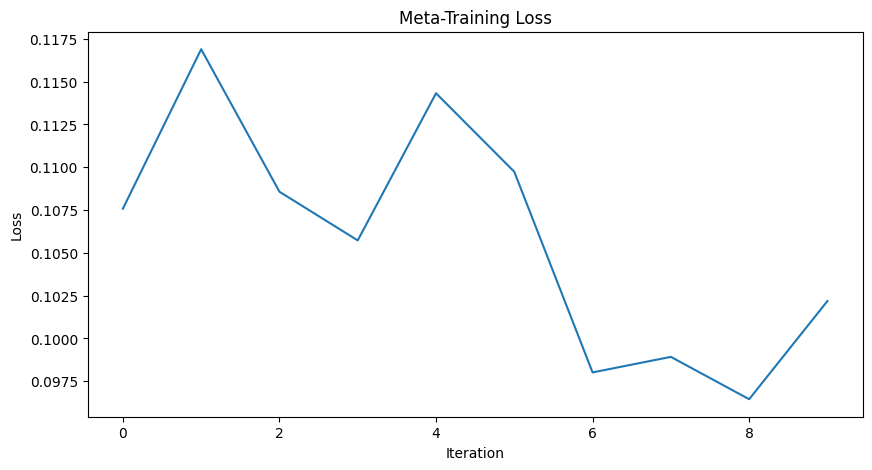

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(meta_train_loss)
plt.title('Meta-Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()
